In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random

In [30]:
import sys
sys.path.append('..')

from yelpsent import data
from yelpsent import features
from yelpsent import metrics
from yelpsent import visualization

# Load Dataset

In [5]:
data_train, data_test = data.load_dataset("../data/yelp_train.json",
                                          "../data/yelp_test.json")

In [6]:
data_train.head()

,review,sentiment
0,"The food was great and unique, we both loved i...",5
1,"So disappointing, don't know if it's the chang...",2
2,"Nice staff and good food, but seems like an un...",3
3,Average Joe's is definitely not average at all...,5
4,"Everything about this place is perfectly fine,...",2


In [7]:
data_train.describe()

,sentiment
count,271915.000000
mean,3.625935
std,1.263561
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [8]:
data_test.head()

,review,sentiment
0,Dropped by on a week night because I was reall...,4
1,"4 of us waited 30 mins for the coffee, got up ...",1
2,Twenty-two dollars for two people for a lunch ...,4
3,I love this place! Great location in the heart...,5
4,I walked an hour across town to get here becau...,5


In [9]:
data_test.describe()

,sentiment
count,90639.000000
mean,3.624091
std,1.263476
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [10]:
X_train = data_train['review'].tolist()
y_train = data_train['sentiment'].tolist()

In [11]:
X_test = data_test['review'].tolist()
y_test = data_test['sentiment'].tolist()

# Build Document-to-Term Matrix

In [12]:
tokenizer = features.get_regexp_tokenizer(r'[a-zA-Z]+')

In [13]:
stop_words = features.get_stop_words('english')

[nltk_data] Downloading package stopwords to /Users/dliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
cv = features.get_count_vectorizer(X_train,
                                   tokenizer=tokenizer,
                                   stop_words=stop_words,
                                   ngram_range=(1,1))

/Users/dliu/anaconda3/envs/yelp/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [17]:
X_train_dtm = cv.transform(X_train)

In [18]:
X_test_dtm = cv.transform(X_test)

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Cross-validation
X_cv_train_dtm, X_cv_val_dtm, y_cv_train, y_cv_val = train_test_split(X_train_dtm, y_train, train_size = 0.75)

In [ ]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c, max_iter=1000)
    lr.fit(X_cv_train_dtm, y_cv_train)
    print ("Validation Accuracy for C=%s: %s" 
           % (c, metrics.accuracy_score(y_cv_val, lr.predict(X_cv_val_dtm))))

In [20]:
clf_lr = LogisticRegression(C=0.01, max_iter=1000).fit(X_train_dtm, y_train)

In [22]:
y_train_pred = clf_lr.predict(X_train_dtm)

In [23]:
print("Training Accuracy:", metrics.accuracy_score(y_train, y_train_pred))

Training Accuracy: 0.6285677509515841


In [24]:
y_test_pred = clf_lr.predict(X_test_dtm)

In [25]:
print("Testing Accuracy:", metrics.accuracy_score(y_test, y_test_pred))

Testing Accuracy: 0.5883229073577599


In [26]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), clf_lr.coef_[0]
    )
}

In [27]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print (best_positive)

('worst', 1.1749447094187455)
('terrible', 0.9715830752322815)
('horrible', 0.9362673441451412)
('awful', 0.8009179554709088)
('disgusting', 0.7724692618794174)
('poisoning', 0.7406529748038542)
('rude', 0.7272244436017395)
('disappointing', 0.688824280190634)
('bland', 0.6613565903226098)
('tasteless', 0.6569750243082234)


In [28]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print (best_negative)

('delicious', -1.0309156188165876)
('amazing', -0.8558928130167213)
('excellent', -0.8144586474608234)
('fantastic', -0.6330478660638968)
('awesome', -0.6323992657931989)
('stars', -0.6271074444672742)
('loved', -0.6256953861730207)
('great', -0.6164194043671789)
('tasty', -0.6094152793889874)
('friendly', -0.6027230280245195)


# Evaluation

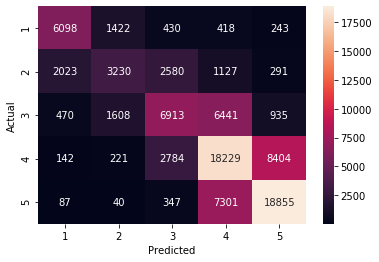

In [37]:
# Confusion matrix
visualization.confusion_heat_map(y_test, y_test_pred, normalize=None, fmt='d', labels=set(y_test))

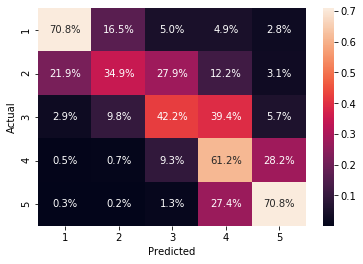

In [38]:
# Confusion matrix, normalized
visualization.confusion_heat_map(y_test, y_test_pred, normalize='true', fmt='.1%', labels=set(y_test))

In [39]:
# Example
example_actual = 3
example_pred = 4
example_incorrects = []
for i in range(len(y_test_pred)):
    if y_test_pred[i] == example_pred and y_test[i] == example_actual:
        example_incorrects.append(i)

In [40]:
r = random.choice(example_incorrects)
print("{0} : {1}".format(r, data_test.loc[r,'review']))

81617 : Nice place to watch games on TV, but for the price you will be paying for a hot-dog you minus well get tickets to see the game live at the ACC.
